In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 99999

import warnings
warnings.filterwarnings("ignore")

def readdata_MT5_Date(market,tf,path,start,stop):
    
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd
    
    while True:

        if not mt5.initialize(path):
            print("initialize() failed, error code =",mt5.last_error())
            quit()
        mk=str(market)
        TF="mt5.TIMEFRAME_"+str(tf)

        start_y , start_m , start_d = start.split("-")
        stop_y , stop_m , stop_d = stop.split("-")
        
        utc_from = datetime(int(start_y), int(start_m), int(start_d))
        utc_to = datetime(int(stop_y), int(stop_m), int(stop_d))
        
        rates = mt5.copy_rates_range(mk, eval(TF), utc_from, utc_to) 
    

        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
        rates_frame.columns=(["time","open","high","low","close","volume"])
        rates_frame=rates_frame.set_index(["time"])
        #rates_frame=rates_frame[(rates_frame.T != 0).any()]
        if rates_frame is not None:
            return rates_frame
            break

def allsymbols(path):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    allsymbol=[]
    symbols=mt5.symbols_get()
    count=0
    for s in symbols:
        count+=1
        allsymbol.append(s.name)
    return allsymbol

def readdata(market,tf,barre,path):
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    
    mk=str(market)
    TF="mt5.TIMEFRAME_"+str(tf)
    bar=barre
    
    cnt=0
    salta=0
    while True:
        cnt=cnt+1
        try:
            rates = mt5.copy_rates_from_pos(mk, eval(TF), 0, bar) #1700
            if len(rates)>0:
                break
        except:
            if cnt<2:
                continue
            else:
                salta=1
                break
    if salta == 0:
        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
        rates_frame.columns=(["time","open","high","low","close","volume"])
        rates_frame=rates_frame.set_index(["time"])
        rates_frame=rates_frame[(rates_frame.T != 0).any()]
        return rates_frame
    else:
        return pd.DataFrame()
    
def get_poin_values(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    tmp=symbol_info_dict['trade_tick_value']/symbol_info_dict['point']
    return tmp

def ordine_market(mercato,quantita,deviazione,path,direzione,commento):
    import time
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    
    mta.initialize(path)
    status=0
    if direzione == "long":
    
        order = Order.as_buy(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    
    if direzione == "short":
    
        order = Order.as_sell(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    while True: 
        r = order.send()
        time.sleep(1)
        if r[7]=='Request executed':
            print(r,'Request executed')
            status=1
            break
        if r[7]=="Market closed":
            print(r[7],"Market closed")
            status=0
            break
    return status

def check_start_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[0]]
    z=list(set(z))
    z.sort()
    return y[0],z[0]

def check_end_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[-1]]
    z=list(set(z))
    z.sort()
    return y[-1],z[-1]

def get_spread(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    try:
        if len(symbol_info)>0:
            return symbol_info.spread
    except:
        return None
    
def get_category(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['path']

def get_ETF(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['description']
    
    
def get_min_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_min

def get_max_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_max

def remove_outlier(y):
    Q1 = np.percentile(y, 10, #25
                       interpolation = 'midpoint')
    Q3 = np.percentile(y, 90, #75
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    y[y>=Q3+1.5*IQR]=0
    y[y<=Q1-1.5*IQR]=0
    return y

def serialize_kmeans_model(kmeans_model):
    
    model_data = {
        'n_clusters': kmeans_model.n_clusters,
        'cluster_centers_': kmeans_model.cluster_centers_.tolist(),
        'labels_': kmeans_model.labels_.tolist(),
        'inertia_': kmeans_model.inertia_,
        'init': kmeans_model.init,
        'n_init': kmeans_model.n_init,
        'max_iter': kmeans_model.max_iter,
        'tol': kmeans_model.tol,
        'algorithm': kmeans_model.algorithm,
        'random_state': kmeans_model.random_state,
        'n_threads' : kmeans_model._n_threads
    }
    return model_data

def recreated_kmeans_model(serialized_kmeans):
    
    from sklearn.cluster import KMeans
    
    kmeans_recreated = KMeans(n_clusters=serialized_kmeans['n_clusters'],
                           init=serialized_kmeans['init'],
                           n_init=serialized_kmeans['n_init'],
                           max_iter=serialized_kmeans['max_iter'],
                           tol=serialized_kmeans['tol'],
                           algorithm=serialized_kmeans['algorithm'],
                           random_state=serialized_kmeans['random_state'])

    kmeans_recreated.cluster_centers_ = serialized_kmeans['cluster_centers_']
    kmeans_recreated.labels_ = serialized_kmeans['labels_']
    kmeans_recreated.inertia_ = serialized_kmeans['inertia_']
    kmeans_recreated._n_threads = serialized_kmeans['n_threads']

    return kmeans_recreated

def get_swap(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.swap_long , symbol_info.swap_short


def get_all_ETF_symbols(path):
    
    all_symbols = allsymbols(path)
    
    ls_temp=[]
    
    for simb in all_symbols:
    
        import MetaTrader5 as mt5
        if not mt5.initialize(path):
            print("initialize() failed, error code =",mt5.last_error())
            quit()
        symbol_info=mt5.symbol_info(simb)
        if symbol_info!=None:
            symbol_info_dict = mt5.symbol_info(simb)._asdict()
        mt5.shutdown()    

        if "ETF" in symbol_info_dict['description']:
            ls_temp.append(simb)
    return ls_temp

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8, 8)  
plt.rcParams['lines.linewidth'] = .5

def drawdown_max(operations):

    equity_cumulata = np.cumsum(operations)
    maxvalue = np.maximum.accumulate(equity_cumulata)
    drawdown = equity_cumulata - maxvalue
    return min(drawdown)

def montecarlo_calmar(operations,iter,sample):

    k = (test.fillna(0)).values
    
    avg_t = []
    avg_dd = []
    for e in range(iter):
        np.random.shuffle(k)
        b=np.random.choice(k, size=int(len(k)*sample))
        avg_t.append(np.sum(b))
        avg_dd.append(abs(drawdown_max(b)))
        
    return np.mean(avg_t)/np.mean(avg_dd)


def detect(data,price,n_days,lookback,fraction_movement):

    np_data = data.T.values
    np_price = price.T.values
    np_open = np_price[0]
    
    pattern_ls=[]
    
    for i in (range(len(np_data[0]))):
        op=np_data[0][i-lookback:i]
        hi=np_data[1][i-lookback:i]
        lo=np_data[2][i-lookback:i]
        cl=np_data[3][i-lookback:i]

        try :
            for n in range(n_days,n_days+1): 
                if  np_open[i+n+1] - np_open[i+1] >= fraction_movement*np_open[i+1]:
                    
                    if i >lookback :
                        #print(np_open[i+n+1] - np_open[i+1],fraction_movement*np_open[i+1],i)
                        a=cl-op
                        body=(a - np.min(a))/np.ptp(a)
                        a=hi-lo
                        range_=(a - np.min(a))/np.ptp(a)
                        info = ["buy",int(n),int(lookback),float(fraction_movement),int(i)]
                        pattern_ls.append([body,range_,info])
                    #print('Down',i,n)
                    break
                elif np_open[i+1] - np_open[i+n+1] >= fraction_movement*np_open[i+1] :
                    
                    if i >lookback :                    
                        #print(np_open[i+1] - np_open[i+n+1],fraction_movement*np_open[i+1],i)
                        a=cl-op
                        body=(a - np.min(a))/np.ptp(a)
                        a=hi-lo
                        range_=(a - np.min(a))/np.ptp(a)
                        info = ["sell",int(n),int(lookback),float(fraction_movement),int(i)]
                        pattern_ls.append([body,range_,info])
                    #print('Up',i,n)
                    break
        except :
            pass

    pattern_detect = np.asarray(pattern_ls, dtype="object")
    
    ls_tmp = []
    for e in pattern_detect[:,2]:
        ls_tmp.append(e[0])
    
    print("Found", len(ls_tmp) ,"patterns")
    print("Buy" ,len([e for e in ls_tmp if "buy" == e]))
    print("Sell" , len(ls_tmp)-(len([e for e in ls_tmp if "buy" == e])))
            
    return pattern_detect

def report(tradelist,initial_capital,type_analisy,Benchmark):
        %matplotlib inline
        import quantstats as qs
        qs.extend_pandas()
    
        tradelist = tradelist.fillna(0)
        tradelist = tradelist[tradelist!=0]
        tradelist.iloc[0] = tradelist.iloc[0]+initial_capital
        tradelist = tradelist.cumsum()
        
        if type_analisy == 0:
            qs.plots.snapshot(tradelist)
            
        if type_analisy == 1:    
            if len(Benchmark)==0:
                qs.reports.basic(tradelist)
            else:
                qs.reports.basic(tradelist,Benchmark)
                
        if type_analisy == 2:    
            if len(Benchmark)==0:
                qs.reports.full(tradelist)
            else:
                qs.reports.full(tradelist,Benchmark)
                

def remove_outlier(y):
    
    high_percentile = 0.99
    low_percentile = 0.01

    lq = np.quantile(y,low_percentile)
    hq = np.quantile(y,high_percentile)
    print(lq,hq)
    y = y.clip(lq,hq)

    return y


In [5]:
def preprocess(history):
    
    dataset=history.copy() #
    open = dataset.open
    high=dataset.high
    low = dataset.low
    close = dataset.close
    volume = dataset.volume

    myBodyD1 = round(abs(open-close),2)
    myBodyD2 = round(abs (open.shift(1)-close.shift(1)),2)
    myBodyD5 = round(abs (open.shift(4)-close),2)

    myAvgPriceD1 = round(((open+high+low+close)/4),2)
    myAvgPriceD2 = round(((open.shift(1)+high.shift(1)+low.shift(1)+close.shift(1))/4),2)
    myAvgPriceD3 = round(((open.shift(2)+high.shift(2)+low.shift(2)+close.shift(2))/4),2)
    myAvgPriceD4 = round(((open.shift(3)+high.shift(3)+low.shift(3)+close.shift(3))/4),2)
    myAvgPriceD5 = round(((open.shift(4)+high.shift(4)+low.shift(4)+close.shift(4))/4),2)

    myMeanAvgPD2 = ((myAvgPriceD1 +myAvgPriceD2 )/2)
    myMeanAvgPD3 = ((myAvgPriceD1 +myAvgPriceD2 +myAvgPriceD3 )/3)
    myMeanAvgPD4 = ((myAvgPriceD1 +myAvgPriceD2 +myAvgPriceD3 +myAvgPriceD4 )/4)
    myMeanAvgPD5 = ((myAvgPriceD1 +myAvgPriceD2 +myAvgPriceD3 +myAvgPriceD4 +myAvgPriceD5)/5)

    myRangeD1 = (high - low)
    myRangeD2 = (high.shift(1) - low.shift(1))
    myRangeD3 = (high.shift(2) - low.shift(2))
    myRangeD4 = (high.shift(3) - low.shift(3))
    myRangeD5 = (high.shift(4) - low.shift(4))

    myRangeMaxD2 = ((high.rolling(2).max()) - (low.rolling(2).min()))
    myRangeMaxD3 = ((high.rolling(3).max()) - (low.rolling(3).min()))
    myRangeMaxD4 = ((high.rolling(4).max()) - (low.rolling(4).min()))
    myRangeMaxD5 = ((high.rolling(5).max()) - (low.rolling(5).min()))
    myRangeMaxD10 = ((high.rolling(10).max()) - (low.rolling(10).min()))

    myRangeMinD2 = abs((high.rolling(2).min()) - (low.rolling(2).max()))
    myRangeMinD3 = abs((high.rolling(3).min()) - (low.rolling(3).max()))
    myRangeMinD4 = abs((high.rolling(4).min()) - (low.rolling(4).max()))
    myRangeMinD5 = abs((high.rolling(5).min()) - (low.rolling(5).max()))
    myRangeMinD10 = abs((high.rolling(10).min()) - (low.rolling(10).max()))

    myRangeDelay1MaxD5 = ((high.shift(1).rolling(5).max()) - (low.shift(1).rolling(5).min()))
    myRangeDelay2MaxD5 = ((high.shift(2).rolling(5).max()) - (low.shift(2).rolling(5).min()))
    myRangeDelay3MaxD5 = ((high.shift(3).rolling(5).max()) - (low.shift(3).rolling(5).min()))
    myRangeDelay4MaxD5 = ((high.shift(4).rolling(5).max()) - (low.shift(4).rolling(5).min()))
    myRangeDelay5MaxD5 = ((high.shift(5).rolling(5).max()) - (low.shift(5).rolling(5).min()))

    myRangeDelay1MaxD10 = ((high.shift(1).rolling(10).max()) - (low.shift(1).rolling(10).min()))
    myRangeDelay2MaxD10 = ((high.shift(2).rolling(10).max()) - (low.shift(2).rolling(10).min()))
    myRangeDelay3MaxD10 = ((high.shift(3).rolling(10).max()) - (low.shift(3).rolling(10).min()))
    myRangeDelay4MaxD10 = ((high.shift(4).rolling(10).max()) - (low.shift(4).rolling(10).min()))
    myRangeDelay5MaxD10 = ((high.shift(5).rolling(10).max()) - (low.shift(5).rolling(10).min()))

    myRangeDelay1MinD5 = abs(((high.shift(1).rolling(5).min()) - (low.shift(1).rolling(5).max())))
    myRangeDelay2MinD5 = abs(((high.shift(2).rolling(5).min()) - (low.shift(2).rolling(5).max())))
    myRangeDelay3MinD5 = abs(((high.shift(3).rolling(5).min()) - (low.shift(3).rolling(5).max())))
    myRangeDelay4MinD5 = abs((high.shift(4).rolling(5).min()) - (low.shift(4).rolling(5).max()))
    myRangeDelay5MinD5 = abs(((high.shift(5).rolling(5).min()) - (low.shift(5).rolling(5).max())))

    myRangeDelay1MinD10 = abs((high.shift(1).rolling(10).min()) - (low.shift(1).rolling(10).max()))
    myRangeDelay2MinD10 = abs((high.shift(2).rolling(10).min()) - (low.shift(2).rolling(10).max()))
    myRangeDelay3MinD10 = abs((high.shift(3).rolling(10).min()) - (low.shift(3).rolling(10).max()))
    myRangeDelay4MinD10 = abs((high.shift(4).rolling(10).min()) - (low.shift(4).rolling(10).max()))
    myRangeDelay5MinD10 = abs((high.shift(5).rolling(10).min()) - (low.shift(5).rolling(10).max()))

    myMaxHighD2 = (high.rolling(2).max()) 
    myMaxHighD3 = (high.rolling(3).max())
    myMaxHighD4 = (high.rolling(4).max())
    myMaxHighD5 = (high.rolling(5).max())

    myMinLowD2 = (low.rolling(2).min()) 
    myMinLowD3 = (low.rolling(3).min())
    myMinLowD4 = (low.rolling(4).min())
    myMinLowD5 = (low.rolling(5).min())

    myMinHighD2 = (high.rolling(2).min())
    myMinHighD3 = (high.rolling(3).min())
    myMinHighD4 = (high.rolling(4).min())
    myMinHighD5 = (high.rolling(5).min())

    myMaxLowD2 = (low.rolling(2).max()) 
    myMaxLowD3 = (low.rolling(3).max())
    myMaxLowD4 = (low.rolling(4).max())
    myMaxLowD5 = (low.rolling(5).max())

    myMinHighD2 = (high.rolling(2).min())
    myMinHighD3 = (high.rolling(3).min())
    myMinHighD4 = (high.rolling(4).min())
    myMinHighD5 = (high.rolling(5).min())

    myMinDelay1LowD2 = (low.shift(1).rolling(2).min()) 
    myMinDelay1LowD3 = (low.shift(1).rolling(3).min())
    myMinDelay1LowD4 = (low.shift(1).rolling(4).min())
    myMinDelay1LowD5 = (low.shift(1).rolling(5).min())

    myMinDelay5LowD2 = (low.shift(4).rolling(2).min())
    myMinDelay5LowD3 = (low.shift(4).rolling(3).min())
    myMinDelay5LowD4 = (low.shift(4).rolling(4).min())
    myMinDelay5LowD5 = (low.shift(4).rolling(5).min())

    myMaxDelay1HighD2 = (high.shift(1).rolling(2).max()) 
    myMaxDelay1HighD3 = (high.shift(1).rolling(3).max())
    myMaxDelay1HighD4 = (high.shift(1).rolling(4).max())
    myMaxDelay1HighD5 = (high.shift(1).rolling(5).max())

    myMaxDelay5HighD2 = (high.shift(4).rolling(2).max())
    myMaxDelay5HighD3 = (high.shift(4).rolling(3).max())
    myMaxDelay5HighD4 = (high.shift(4).rolling(4).max())
    myMaxDelay5HighD5 = (high.shift(4).rolling(5).max())

    #########
    myMaxDelay1LowD2 = (low.shift(1).rolling(2).max()) 
    myMaxDelay1LowD3 = (low.shift(1).rolling(3).max())
    myMaxDelay1LowD4 = (low.shift(1).rolling(4).max())
    myMaxDelay1LowD5 = (low.shift(1).rolling(5).max())

    myMaxDelay5LowD2 = (low.shift(4).rolling(2).max())
    myMaxDelay5LowD3 = (low.shift(4).rolling(3).max())
    myMaxDelay5LowD4 = (low.shift(4).rolling(4).max())
    myMaxDelay5LowD5 = (low.shift(4).rolling(5).max())

    myMinDelay1HighD2 = (high.shift(1).rolling(2).min()) 
    myMinDelay1HighD3 = (high.shift(1).rolling(3).min())
    myMinDelay1HighD4 = (high.shift(1).rolling(4).min())
    myMinDelay1HighD5 = (high.shift(1).rolling(5).min())

    myMinDelay5HighD2 = (high.shift(4).rolling(2).min())
    myMinDelay5HighD3 = (high.shift(4).rolling(3).min())
    myMinDelay5HighD4 = (high.shift(4).rolling(4).min())
    myMinDelay5HighD5 = (high.shift(4).rolling(5).min())

    myAvgLowD2 = (low.rolling(2).mean())
    myAvgLowD3 = (low.rolling(3).mean())
    myAvgLowD4 = (low.rolling(4).mean())
    myAvgLowD5 = (low.rolling(5).mean())

    myAvgHighD2 = (high.rolling(2).mean())
    myAvgHighD3 = (high.rolling(3).mean())
    myAvgHighD4 = (high.rolling(4).mean())
    myAvgHighD5 = (high.rolling(5).mean())

    myAvgCloseD2 = (close.rolling(2).mean())
    myAvgCloseD3 = (close.rolling(3).mean())
    myAvgCloseD4 = (close.rolling(4).mean())
    myAvgCloseD5 = (close.rolling(5).mean())
 
    
    dataset["p1"] = myBodyD1<(0.1*myRangeD1)
    dataset["p2"] = myBodyD1<(0.25*myRangeD1)
    dataset["p3"] = myBodyD1<(0.5*myRangeD1)
    dataset["p4"] = myBodyD1<(0.75*myRangeD1)
    dataset["p5"] = myBodyD1>(0.25*myRangeD1)#versione false di p2
    dataset["p6"] = myBodyD1>(0.5*myRangeD1) #versione false di p3
    dataset["p7"] = myBodyD1>(0.75*myRangeD1) #versione false di p4
    dataset["p8"] = myBodyD1>(1*myRangeD1)
    dataset["p9"] = myBodyD1<(0.5*myRangeD5)
    dataset["p10"] = myBodyD1<(0.5*myRangeMaxD10)
    dataset["p11"] = myBodyD5<(0.1*(high.shift(4)-low))
    dataset["p12"] = myBodyD5<(0.25*(high.shift(4)-low))
    dataset["p13"] = myBodyD5<(0.50*(high.shift(4)-low))
    dataset["p14"] = myBodyD5<(0.75*(high.shift(4)-low))
    dataset["p15"] = myBodyD5<(1*(high.shift(4)-low))
    dataset["p16"] = myBodyD5<(1.5*(high.shift(4)-low))
    dataset["p17"] = myBodyD5<(2*(high.shift(4)-low))
    dataset["p18"] = myBodyD5>(0.25*(high.shift(4)-low))  #versione false di p12
    dataset["p19"] = myBodyD5>(0.50*(high.shift(4)-low))  #versione false di p13
    dataset["p20"] = myBodyD5>(0.75*(high.shift(4)-low))  #versione false di p14
    dataset["p21"] = myBodyD5>(1*(high.shift(4)-low))     #versione false di p15
    dataset["p22"] = myBodyD5>(1.5*(high.shift(4)-low))   #versione false di p16
    dataset["p23"] = myBodyD5>(2*(high.shift(4)-low))     #versione false di p17
    dataset["p24"] = myBodyD5>(2.5*(high.shift(4)-low))
    dataset["p25"] = myBodyD5<(0.1*myRangeD5)
    dataset["p26"] = myBodyD5<(0.25*myRangeD5)
    dataset["p27"] = myBodyD5<(0.5*myRangeD5)
    dataset["p28"] = myBodyD5<(0.75*myRangeD5)
    dataset["p29"] = myBodyD5>(0.1*myRangeD5)  #versione false di p25
    dataset["p30"] = myBodyD5>(0.25*myRangeD5) #versione false di p26
    dataset["p31"] = myBodyD5>(0.5*myRangeD5)  #versione false di p27
    dataset["p32"] = myBodyD5>(0.75*myRangeD5) #versione false di p28
    dataset["p33"] = (close>close.shift(1))&(close.shift(1)>close.shift(2))&(close.shift(2)>close.shift(3))
    dataset["p34"] = (close<close.shift(1))&(close.shift(1)<close.shift(2))&(close.shift(2)<close.shift(3))   #versione false di p33
    dataset["p35"] = (close>close.shift(1))&(close.shift(1)>close.shift(2))&(close.shift(2)>close.shift(3))&(close.shift(3)>close.shift(4))
    dataset["p36"] = (close<close.shift(1))&(close.shift(1)<close.shift(2))&(close.shift(2)<close.shift(3))&(close.shift(3)<close.shift(4)) #versione false di p35
    dataset["p37"] = (high>high.shift(1))&(low>low.shift(1))
    dataset["p38"] = (high<high.shift(1))&(low<low.shift(1)) #versione false di p37
    dataset["p39"] = (close>close.shift(1))
    dataset["p40"] = (close<close.shift(1)) #versione false di p39
    dataset["p41"] = (close<open)
    dataset["p42"] = (close>open)  #versione false di p41
    dataset["p43"] = (close<(close.shift(1)-(close.shift(1)*0.5*0.01)))
    dataset["p44"] = (close<(close.shift(1)-(close.shift(1)*1*0.01)))
    dataset["p45"] = (close<(close.shift(1)-(close.shift(1)* 1.5*0.01)))
    dataset["p46"] = (close<(close.shift(1)-(close.shift(1)*2*0.01)))
    dataset["p47"] = (close<(close.shift(1)-(close.shift(1)*2.5*0.01)))
    dataset["p48"] = (close<(close.shift(1)-(close.shift(1)*3*0.01)))
    dataset["p49"] = (close>(close.shift(1)+(close.shift(1)*0.5*0.01)))  
    dataset["p50"] = (close>(close.shift(1)+(close.shift(1)*1*0.01)))
    dataset["p51"] = (close>(close.shift(1)+(close.shift(1)*1.5*0.01)))
    dataset["p52"] = (close>(close.shift(1)+(close.shift(1)*2*0.01)))
    dataset["p53"] = (close>(close.shift(1)+(close.shift(1)*2.5*0.01)))
    dataset["p54"] = (close>(close.shift(1)+(close.shift(1)*3*0.01)))
    dataset["p55"] = (high)>(high.shift(4))
    dataset["p56"] = (high)<(high.shift(4))  # versione false di p55
    dataset["p57"] = (low)>(low.shift(4))
    dataset["p58"] = (low)<(low.shift(4))   # versione false di p57
    dataset["p59"] = (high>high.shift(1))&(high>high.shift(2))&(high>high.shift(3))
    dataset["p60"] = (high<high.shift(1))&(high<high.shift(2))&(high<high.shift(3)) # versione false di p59
    dataset["p61"] = (low<low.shift(1))&(low<low.shift(2))&(low<low.shift(3))
    dataset["p62"] = (low>low.shift(1))&(low>low.shift(2))&(low>low.shift(3)) #versione false di p62
    dataset["p63"] = (close>close.shift(1))&(close>close.shift(2))&(close>open)
    dataset["p64"] = (close<close.shift(1))&(close<close.shift(2))&(close<open)
    dataset["p65"] = (high-close)<0.20*myRangeD1
    dataset["p66"] = (close-low)<0.20*myRangeD1
    dataset["p67"] = (myRangeD1<(((high.shift(1)-low.shift(1))+(high.shift(1)-low.shift(1)))/3))
    dataset["p68"] = (myRangeD1<myRangeD2)&(myRangeD2<myRangeD3)
    dataset["p69"] = (high.shift(1)>high)&(low.shift(1)<low)
    dataset["p68"] = (high<high.shift(1))
    dataset["p69"] = (low>low.shift(1))
    dataset["p70"] = (low<low.shift(1))   # versione false di p69
    dataset["p71"] = (high.shift(1)>high)|(low.shift(1)<low)
    dataset["p72"] = (high.shift(1)<high)&(low.shift(1)>low)
    dataset["p73"] = (close>open) & (close.shift(1)>open.shift(1))
    dataset["p74"] = (close<open) & (close.shift(1)>open.shift(1))
    dataset["p75"] = (close<open) & (close.shift(1)<open.shift(1))  # versione false di p73
    dataset["p76"] = (abs(open.shift(1)-close)) < (0.5*(myMaxHighD2 - myMinLowD2))
    dataset["p77"] = (high> high.shift(1))     
    dataset["p78"] = (high> high.shift(1)) & (high> high.shift(2))
    dataset["p79"] = (high< high.shift(1)) & (high< high.shift(2))  # versione false di p78
    dataset["p80"] = (low<low.shift(1))
    dataset["p81"] = (low>low.shift(1)) & ((low>low.shift(2)))
    dataset["p82"] = (low<low.shift(1)) & ((low<low.shift(2)))
    dataset["p83"] = (high>high.shift(1)) & (low>low.shift(1)) & (high.shift(1)<high.shift(2)) & (low.shift(1)<low.shift(2))
    dataset["p84"] = (high<high.shift(1)) & (low<low.shift(1)) & (high.shift(1)>high.shift(2)) & (low.shift(1)>low.shift(2))
    dataset["p85"] = (close>close.shift(1)) & (close.shift(1)>close.shift(2))
    dataset["p86"] = (close<close.shift(1)) & (close.shift(1)<close.shift(2)) # versione false di p85
    dataset["p87"] = (myAvgPriceD1 > myAvgPriceD2)
    dataset["p88"] = (myAvgPriceD1 > myAvgPriceD2) & (myAvgPriceD1 > myAvgPriceD3)
    dataset["p89"] = (myAvgPriceD1 < myAvgPriceD2)  # versione false di p87
    dataset["p90"] = (myAvgPriceD1 < myAvgPriceD2) & (myAvgPriceD1 < myAvgPriceD3) # versione false di p88
    dataset["p91"] = (close>high.shift(1))  
    dataset["p92"] = (close<low.shift(1)) 
    dataset["p93"] = (close>high.shift(1)) & (close>high.shift(2)) 
    dataset["p94"] = (close<low.shift(1)) & (close<low.shift(2)) 
    dataset["p95"] = (close>high.shift(1)) & (close>high.shift(2)) & (close>high.shift(3))
    dataset["p96"] = (close<low.shift(1)) & (close<low.shift(2)) & (close<low.shift(3)) # versione false di p95
    dataset["p97"] = (close>high.shift(1)) & (close>open) & (close.shift(1)<open.shift(1))
    dataset["p98"] = (close<low.shift(1)) & (close<open) & (close.shift(1)>open.shift(1))# versione false di p95
    dataset["p99"] = (myRangeD1<myRangeD2)
    dataset["p100"] = (myRangeD1<myRangeD5)
    dataset["p101"] = (myRangeD1<myRangeMaxD10)
    dataset["p102"] = (myRangeD1>myRangeDelay1MaxD10)
    dataset["p103"] = (close>myMaxDelay1HighD4)
    dataset["p104"] = (close>myMaxDelay1HighD5)
    dataset["p105"] = (close<myMinDelay1LowD4)
    dataset["p106"] = (close<myMinDelay1LowD5)
    dataset["p107"] = (open.shift(-1)>high) #GapUp Utilizzo shift(-1) vedi codice gapfiller
    dataset["p108"] = (open.shift(-1)<low) #GapDown Utilizzo shift(-1) vedi codice gapfiller
    dataset["p109"] = ((open.shift(-1)>close) & (open.shift(-1)<high)) #LapUp Utilizzo shift(-1) vedi codice gapfiller
    dataset["p110"] = ((open.shift(-1)<close) & (open.shift(-1)>low))  #LapDown Utilizzo shift(-1) vedi codice gapfiller
    dataset["p111"] = (open.shift(-1)>close) #CapUp Utilizzo shift(-1) vedi codice gapfiller
    dataset["p112"] = (open.shift(-1)<close) #LapDown Utilizzo shift(-1) vedi codice gapfiller 
    dataset["p113"] = (open<close.shift(1))
    dataset["p114"] = (low<low.shift(2))
    dataset["p115"] = ((high-low))<((high.shift(1)-low.shift(1)))
    dataset["p116"] = (high>high.shift(2))
    dataset["p117"] = (low<low.shift(1))
    dataset["p118"] = (high>high.shift(1))
    dataset["p119"] = (abs(open.shift(4)-close))<0.66*(myMaxHighD5-myMinLowD5)
    dataset["p120"] = (abs(open-close))<0.66*(myMaxHighD5-myMinLowD5)
    dataset["p121"] = (abs(open-close))<0.66*(high-low)
    dataset["p122"] = (high-low)>0.66*(((high-low)+\
                (high.shift(1)-low.shift(1))+(high.shift(2)-low.shift(2))+\
                (high.shift(3)-low.shift(3)))/4)
    dataset["p123"] = (high-low)<0.66*(((high-low)+\
                (high.shift(1)-low.shift(1))+(high.shift(2)-low.shift(2))+\
                (high.shift(3)-low.shift(3)))/4)
    #dataset["p124"] = abs((mtk.weekly_open_1-mtk.weekly_close_1)<0.75*(mtk.weekly_high_1-mtk.weekly_low_1))
    #dataset["p125"] = abs((mtk.weekly_open_1-mtk.weekly_close_1)<0.50*(mtk.weekly_high_1-mtk.weekly_low_1))
    #dataset["p126"] = abs((mtk.weekly_open_1-mtk.weekly_close_1)<0.25*(mtk.weekly_high_1-mtk.weekly_low_1))
    dataset["p127"] = ((high.shift(3)-low.shift(3))<(high.shift(2)-low.shift(2)))&((high.shift(2)-low.shift(2))<(high.shift(1)-low.shift(1)))&((high.shift(1)-low.shift(1))<(high-low))
    dataset["p128"] = ((high.shift(2)-low.shift(2))<(high.shift(1)-low.shift(1)))&((high.shift(1)-low.shift(1))<(high-low))
    dataset["p129"] = ((high.shift(3)-low.shift(3))>(high.shift(2)-low.shift(2)))&((high.shift(2)-low.shift(2))>(high.shift(1)-low.shift(1)))&((high.shift(1)-low.shift(1))>(high-low))  # versione false di p127
    dataset["p130"] = ((high.shift(2)-low.shift(2))>(high.shift(1)-low.shift(1)))&((high.shift(1)-low.shift(1))>(high-low)) # versione false di p128
    dataset["p131"] = (close-low)<(high-low)/4
    dataset["p132"] = (high-close)<(high-low)/4
    dataset["p133"] = (close-low)<(high-low)/3
    dataset["p134"] = (high-close)<(high-low)/4
    dataset["p135"] = (close-low)<(high-low)/2
    dataset["p136"] = (high-close)<(high-low)/2
    dataset["p137"] = (open.shift(0)>high)
    dataset["p138"] = (open.shift(0)<high)# versione false di p137 
    dataset["p139"] = (open.shift(0)<low)
    dataset["p140"] = (open<=high.shift(1))
    dataset["p141"] = (open>high.shift(1))# versione false di p140
    dataset["p142"] = (open>low.shift(2))
    dataset["p143"] = (open>open.shift(1))
    dataset["p144"] = (open<open.shift(1)) # versione false di p143
    dataset["p145"] = (close>low.shift(1))
    dataset["p146"] = (close<low.shift(1)) # versione false di p145
    dataset["p147"] = (close>close.shift(1))
    dataset["p148"] = (close<close.shift(1)) # versione false di p147
    dataset["p149"] = (close.shift(1)<close.shift(2))

    return dataset.iloc[:,5:]

In [7]:
def resample_standard_session(original_tf,resample_tf,dataset):
    
    original_tf=int(original_tf.replace("Min",""))
    resample_tf=int(resample_tf.replace("Min",""))
    df_0=dataset.copy()
    
    df_0.index=df_0.index - pd.DateOffset(minutes=original_tf)
    df_resample=df_0.resample(str(resample_tf)+'Min').agg({'open' : 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last','volume':'sum'})
    
    if resample_tf == 1440 :
        df_resample = df_resample
    else:
        df_resample.index=df_resample.index + pd.DateOffset(minutes=resample_tf)
        
    df_resample=df_resample.dropna()
    return df_resample

import os
os.chdir(r"C:\Users\Drako\TS_API\06032023")
ls_mercati = os.listdir()

BIGPOINTVALUE = 1000

simbolo = "@US_60Minute_2023-10-10.csv"

dataset = pd.read_csv(simbolo , index_col="date_time" , parse_dates=["date_time"])
simbolo = simbolo.split("_")[0]
dataset.tail()

,open,high,low,close,volume
date_time,,,,,
2023-10-09 19:00:00,111.84375,112.09375,111.81250,112.00000,17117
2023-10-09 20:00:00,112.03125,112.18750,111.96875,112.12500,13150
2023-10-09 21:00:00,112.12500,112.25000,112.00000,112.03125,2821
2023-10-09 23:00:00,112.00000,112.12500,111.96875,112.09375,2335
2023-10-10 00:00:00,112.09375,112.34375,112.03125,112.25000,3538


<Axes: xlabel='H'>

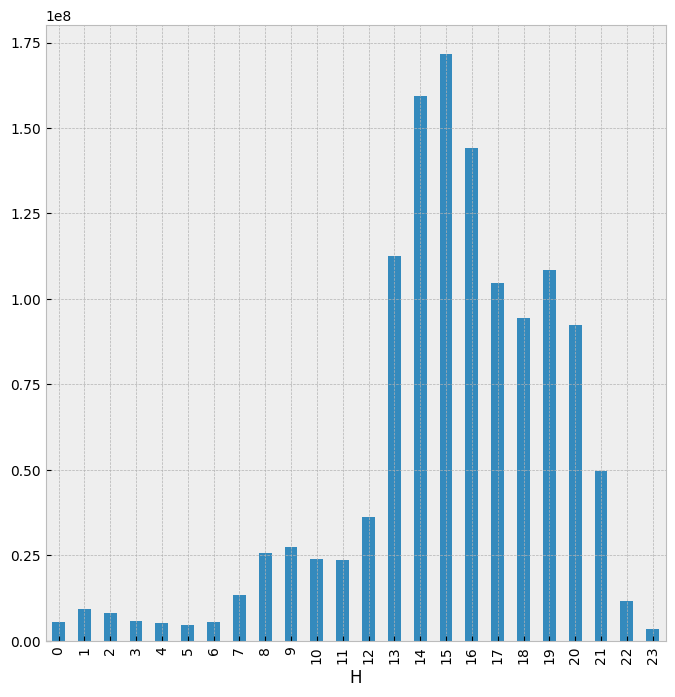

In [8]:
dataset["H"]=dataset.index.hour
dataset.groupby("H").sum().volume.plot.bar()

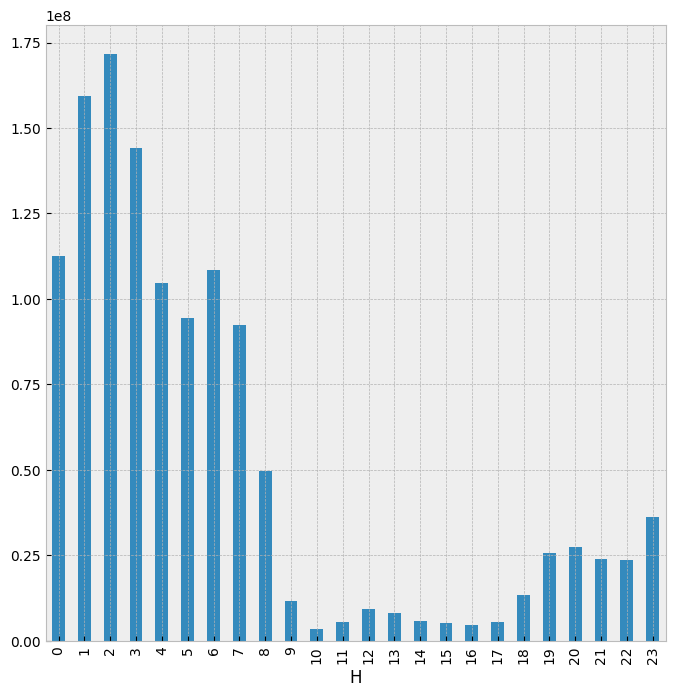

,open,high,low,close,volume
date_time,,,,,
2023-10-04,111.87500,112.15625,109.62500,111.59375,735480
2023-10-05,111.62500,111.90625,110.71875,111.09375,570160
2023-10-06,111.09375,111.68750,108.90625,109.31250,474940
2023-10-09,110.56250,111.56250,110.34375,111.21875,95470
2023-10-10,111.21875,112.34375,110.68750,112.25000,99283


In [9]:
dataset.index=dataset.index.tz_localize("UTC").tz_convert("Etc/GMT-11")
dataset.index=dataset.index.tz_localize(None)

dataset["H"]=dataset.index.hour
dataset.groupby("H").sum().volume.plot.bar()
plt.show()


dataset_0 = resample_standard_session("60Min","1440Min",dataset)
dataset_0 = dataset_0[dataset_0.index.dayofweek<5]
dataset_ = resample_standard_session("60Min","1440Min",dataset)
dataset_0.tail()

In [89]:
dataset=dataset_0.copy()
X0 = preprocess(dataset)
X0 = X0.copy()
X0.tail()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p140,p141,p142,p143,p144,p145,p146,p147,p148,p149
date_time,,,,,,,,,,,,,,,,,,,,,
2023-10-04,False,True,True,True,False,False,False,False,True,True,...,True,False,False,False,True,True,False,False,True,True
2023-10-05,False,False,True,True,True,False,False,False,True,True,...,True,False,True,False,True,True,False,False,True,True
2023-10-06,False,False,False,True,True,True,False,False,False,True,...,True,False,True,False,True,False,True,False,True,True
2023-10-09,False,False,False,True,True,True,False,False,True,True,...,True,False,False,False,True,True,False,True,False,True
2023-10-10,False,False,False,True,True,True,False,False,True,True,...,True,False,True,True,False,True,False,True,False,False


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from IPython.display import clear_output
from sklearn.model_selection import cross_val_predict , TimeSeriesSplit
from sklearn.metrics import accuracy_score

In [12]:

dataset["PNL"] = (dataset.open.shift(-1)-dataset.open)*BIGPOINTVALUE 
dataset["PNL"] = dataset["PNL"] .fillna(0)

y0=   dataset["PNL"].copy().to_frame()
y0[y0>0]=1
y0[y0<0]=-1
y0=y0.shift(-1,fill_value=1)
y0[y0==0]=1
y0=y0.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X0.loc[:"2023-01-01"], y0.loc[:"2023-01-01"], test_size=0.1, random_state=1,shuffle=False) 
OOS = y_test.index[0]
OOS

Timestamp('2021-05-17 00:00:00')

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
global feature_names
feature_names = []

def fitness_function(params):
    min_samples_split, max_depth, n_estimators = params
    
    clf = RandomForestClassifier(random_state=42,n_jobs=-1,
        min_samples_split= int(min_samples_split) if int(min_samples_split) >= 1 else 1,
        max_depth=int(max_depth) if int(max_depth) >= 1 else 1,
        n_estimators=int(n_estimators) if int(n_estimators) >= 1 else 1)

    validation_data = len(X_train) - int(len(X_train)*0.9)

    clf.fit (X_train.iloc[validation_data:], y_train.iloc[validation_data:]) 
   

    importances = clf.feature_importances_
    importance_percentage = (importances / importances.sum()) * 100
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance Percentage': importance_percentage})
    feature_importance_df = feature_importance_df.sort_values(by='Importance Percentage', ascending=False)  
    selected_features = feature_importance_df.Feature[:10].values
    
 
    feature_names.append([params , list(selected_features)])
    
    clf.fit (X_train[selected_features].iloc[validation_data:], y_train.iloc[validation_data:])
      
    cv_scores = cross_val_predict(clf, X_train[selected_features].iloc[validation_data:], y_train.iloc[validation_data:], cv=40 , method='predict_proba' , n_jobs=-1)   
    
    threshold = 0.6
    cv_scores[:,0] = np.where(cv_scores[:,0]>threshold ,-1,0) 
    cv_scores[:,1] = np.where(cv_scores[:,1]>threshold ,1,0)
    cv_scores = np.sum(cv_scores , axis=1)
    
    ac = accuracy_score(y_train.iloc[validation_data:], cv_scores)
    
    pred = clf.predict(X0[selected_features].loc[:"2023-01-01"].values)
    pred_proba = clf.predict_proba(X0[selected_features].loc[:"2023-01-01"].values)
    
    proba = (np.amax(pred_proba, axis=1) > threshold).astype(int)
    cc = dataset.PNL.loc[:"2023-01-01"].to_frame().copy()
    cc["pred"] = pred
    cc["pred"][cc["pred"]==0]=-1
    cc["proba"] = proba
    cc["clean_pred"] = np.where(cc["proba"]==0,0,cc.pred)
    cc["nb"] = cc.PNL*cc["clean_pred"].shift(1)
    cc = cc.fillna(0)   

    #cc["nb"].cumsum().plot(title=str(study.trials[-1].number))
    #plt.show()
    tf= cc["nb"].iloc[:validation_data].values
    tf2 = cc["nb"].loc[y_train.index[-1]:].values

    
    if (sum(tf2)>0) & (sum(tf)>0):
        return   [1+ac] 
    else:
        return   [ac/2] 

In [14]:
import random
from deap import base, creator, tools, algorithms

# Crea un tipo di fitness (massimizzazione)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Crea un individuo (una soluzione) con tre parametri interi
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_int_min_samples_split", random.randint, 2, 100)
toolbox.register("attr_int_max_depth", random.randint, 1, 30)  #30
toolbox.register("attr_int_n_estimators", random.randint, 1, 30)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_int_min_samples_split,
                                                                 toolbox.attr_int_max_depth,
                                                                 toolbox.attr_int_n_estimators), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
# Registra gli operatori genetici
toolbox.register("evaluate", fitness_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate_min_samples_split", tools.mutUniformInt, low=2, up=100, indpb=0)
toolbox.register("mutate_max_depth", tools.mutUniformInt, low=1, up=30, indpb=0)
toolbox.register("mutate_n_estimators", tools.mutUniformInt, low=1, up=30, indpb=0)
toolbox.register("select", tools.selTournament, tournsize=3)

# Crea la popolazione iniziale
population = toolbox.population(n=100)  # Puoi regolare il numero di individui iniziali

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

hof = tools.HallOfFame(30)

# Esegui l'algoritmo genetico
log_book = algorithms.eaMuPlusLambda(population, toolbox, mu=5, lambda_=10, cxpb=0.9, mutpb=0.1, ngen=5, stats=stats, halloffame=hof, verbose=True) # cxpb=0.7, mutpb=0.2

#log_book = algorithms.eaSimple(population, toolbox, 0.95, 0.3 , 3, stats, halloffame=hof ,verbose=1) 

# Restituisci la migliore soluzione trovata
best_individual = tools.selBest(population, k=1)[0]
best_params_ = {
    "min_samples_split": best_individual[0],
    "max_depth": best_individual[1],
    "n_estimators": best_individual[2]
}
print("")
print("Migliori parametri:", best_params_)

best_params_ = best_individual
best_params_

gen	nevals	avg     	std     	min	max   
0  	100   	0.345083	0.473013	0  	1.2049
1  	10    	0.66871 	0.48821 	0.045826	1.10508
2  	10    	0.883508	0.418863	0.0521016	1.16696
3  	10    	1.10677 	0.0308734	1.08727  	1.16696
4  	10    	1.12078 	0.0286336	1.08727  	1.16696
5  	10    	1.15458 	0.0247519	1.10508  	1.16696

Migliori parametri: {'min_samples_split': 16, 'max_depth': 28.88670287867464, 'n_estimators': 11}


[16, 28.88670287867464, 11]

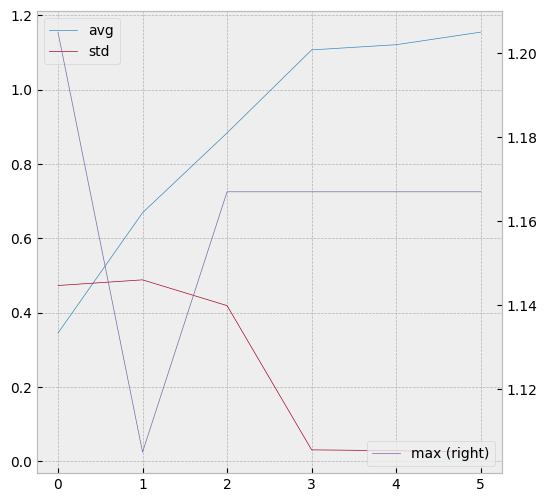

In [15]:
log=pd.DataFrame(log_book[1])
log[["avg","std"]].plot(figsize=(6,6))
plt.legend(loc=2)

log["max"].plot(secondary_y=True)
plt.legend(loc=4)
plt.show()

3

  0%|          | 0/30 [00:00<?, ?it/s]

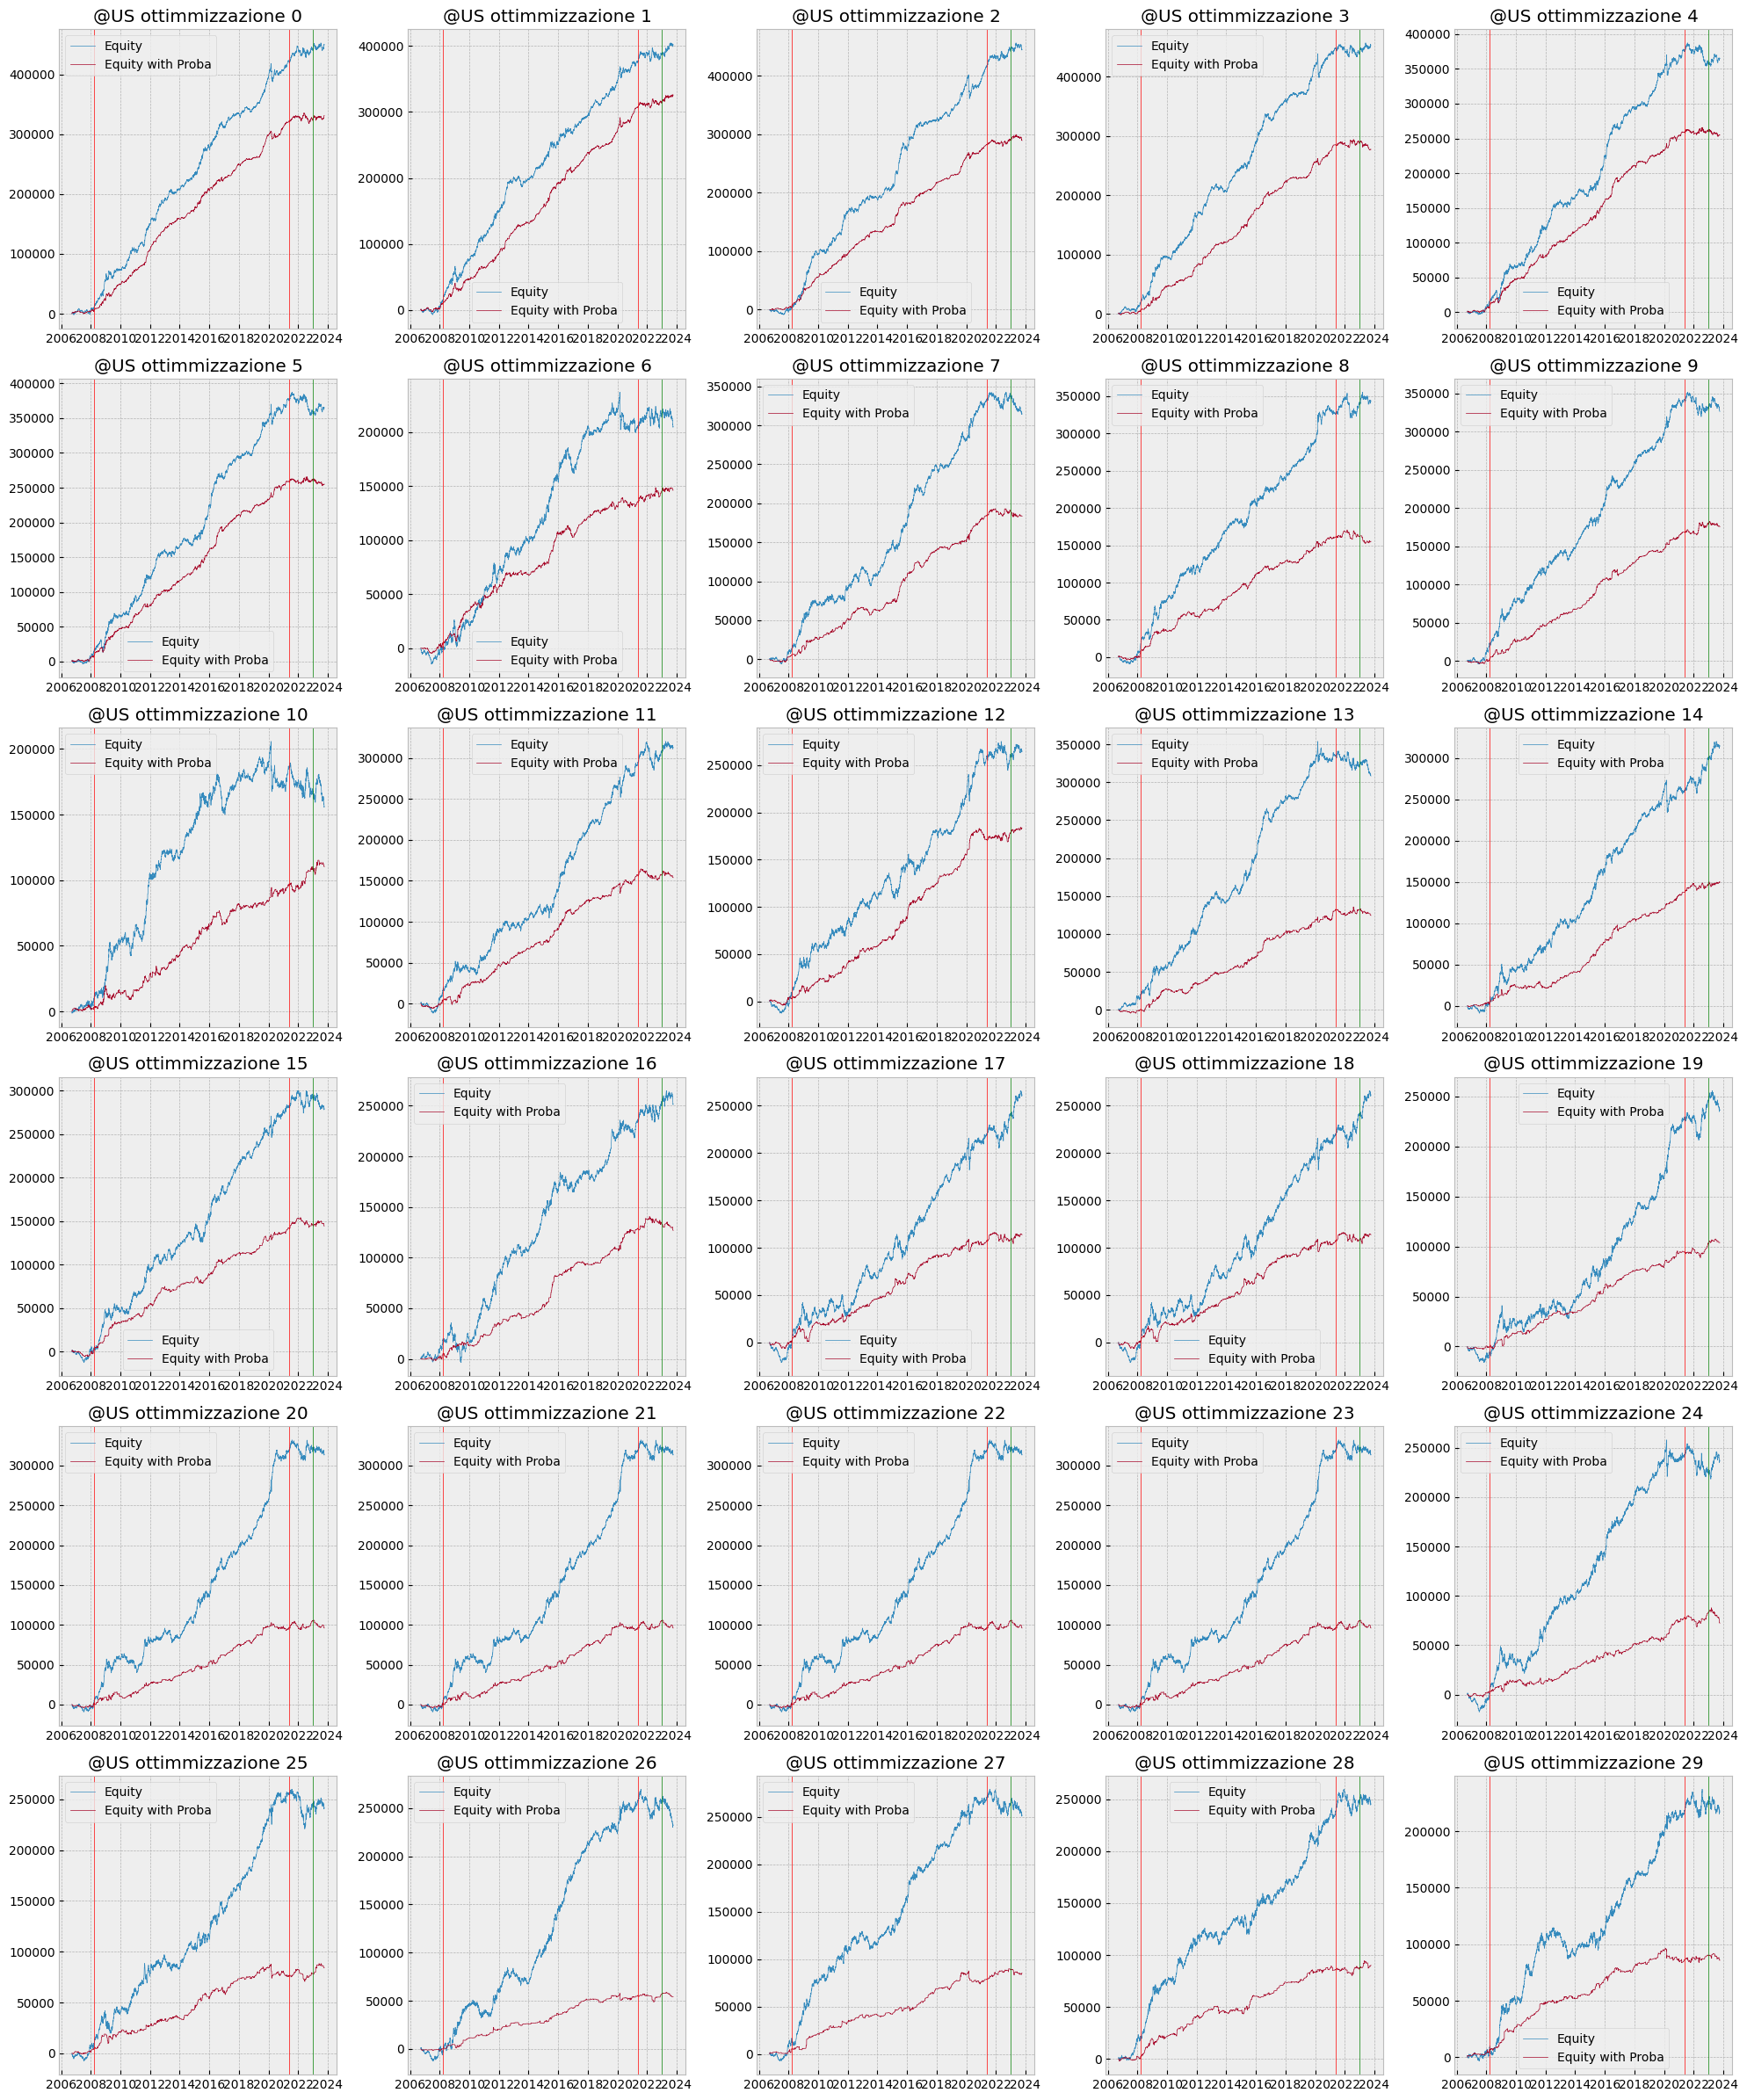

In [64]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

num_iterazioni = len(hof)

# Specifica il numero di grafici per riga
grafici_per_riga = 5

# Calcola il numero di righe necessarie
num_righe = (num_iterazioni + grafici_per_riga - 1) // grafici_per_riga

# Calcola le dimensioni della figura principale
larghezza_figura = 20
altezza_figura = num_righe * 4

# Crea la figura principale
fig = plt.figure(figsize=(larghezza_figura, altezza_figura))

for i in tqdm(range(num_iterazioni)):
    best_params_ = hof[i]
    # ... il tuo codice per l'elaborazione dei dati e la creazione del grafico

    # Aggiungi il grafico a una subplot all'interno della griglia
    ax = fig.add_subplot(num_righe, grafici_per_riga, i + 1)

    # Esegui il tuo codice qui
    best_params = hof[i]
    best_params = [e for e in feature_names if best_params == e[0]]
    best_params = best_params[-1]
    #print(best_params[0])
    best_min_samples_split = int(best_params[0][0]) if int(best_params[0][0]) >= 1 else 1
    best_max_depth = int(best_params[0][1]) if int(best_params[0][1]) >= 1 else 1
    best_n_estimators = int(best_params[0][2]) if int(best_params[0][2]) >= 1 else 1
    selected_features = best_params[1]
    #display(selected_features)
    best_clf = RandomForestClassifier(random_state=42, n_jobs=-1,
        min_samples_split=best_min_samples_split,
        max_depth=best_max_depth,
        n_estimators=best_n_estimators)

    validation_data = len(X_train) - int(len(X_train) * 0.9)
    costi = 0

    best_clf.fit(X_train[selected_features].iloc[validation_data:], y_train.iloc[validation_data:])
    #clear_output(wait=True)
    pred = best_clf.predict(X0[selected_features].values)

    pred_proba = best_clf.predict_proba(X0[selected_features].values)
    proba = (np.amax(pred_proba, axis=1) > 0.6).astype(int)

    cc = dataset.PNL.to_frame().copy()
    cc["pred"] = pred
    cc["pred"][cc["pred"] == 0] = -1

    cc["proba"] = proba
    cc["clean_pred"] = np.where(cc["proba"] == 0, 0, cc.pred)

    cc["costi"] = np.where((cc.pred != cc.pred.shift(1)), -costi, 0)
    cc["costi_proba"] = np.where((cc.clean_pred != cc.clean_pred.shift(1)), -costi, 0)

    cc["nb"] = cc.PNL * cc.pred.shift(1)
    cc["nb"] = cc["nb"] + cc["costi"]
    cc["nb_proba"] = cc.PNL * cc["clean_pred"].shift(1)
    cc["nb_proba"] = cc["nb_proba"] + cc["costi_proba"]
    cc = cc.fillna(0)

    # Plotta il grafico
    ax.plot(cc["nb"].cumsum(), label="Equity")
    ax.plot(cc["nb_proba"].cumsum(), label="Equity with Proba")
    ax.axvline(x=y_train.index[validation_data], color="red")
    ax.axvline(x=y_train.index[-1], color="red")
    data_limite = datetime.strptime("2023-01-01", "%Y-%m-%d")
    ax.axvline(x=data_limite, color="green")
    ax.set_title(simbolo+" ottimmizzazione "+str(i))
    ax.legend()

# Regola lo spaziamento tra i grafici
plt.tight_layout()

# Mostra la figura con la griglia di grafici
plt.show()


In [88]:
best_params_ = hof[1]

best_params = [e for e in feature_names if best_params_ == e[0] ]
best_params = best_params[-1]
print(best_params[0])
best_min_samples_split= int(best_params[0][0]) if int(best_params[0][0]) >= 1 else 1
best_max_depth=int(best_params[0][1]) if int(best_params[0][1]) >= 1 else 1
best_n_estimators=int(best_params[0][2]) if int(best_params[0][2]) >= 1 else 1
selected_features = best_params[1]
display(selected_features)

best_clf = RandomForestClassifier(random_state=42,n_jobs=-1,
    min_samples_split=best_min_samples_split,
    max_depth=best_max_depth,
    n_estimators=best_n_estimators)



[3, 28, 12]


['p100', 'p113', 'p111', 'p109', 'p119', 'p9', 'p76', 'p110', 'p67', 'p128']

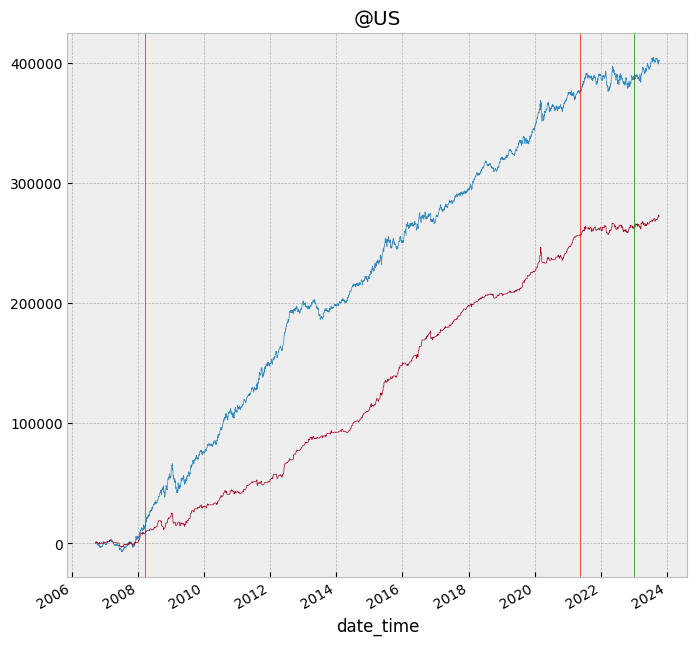

In [86]:
from IPython.display import clear_output

validation_data = len(X_train) - int(len(X_train)*0.9)
costi = 0

best_clf.fit(X_train[selected_features].iloc[validation_data:], y_train.iloc[validation_data:]) 
#clear_output(wait=True)
pred = best_clf.predict(X0[selected_features].values)

pred_proba = best_clf.predict_proba(X0[selected_features].values)
proba = (np.amax(pred_proba, axis=1) > 0.62).astype(int)

cc = dataset.PNL.to_frame().copy()
cc["pred"] = pred
cc["pred"][cc["pred"]==0]=-1

cc["proba"] = proba
cc["clean_pred"] = np.where(cc["proba"]==0,0,cc.pred)

cc["costi"] = np.where((cc.pred!=cc.pred.shift(1)),-costi,0)
cc["costi_proba"] = np.where((cc.clean_pred!=cc.clean_pred.shift(1)),-costi,0)

cc["nb"] = cc.PNL*cc.pred.shift(1)
cc["nb"] = cc["nb"] + cc["costi"] 
cc["nb_proba"] = cc.PNL*cc["clean_pred"].shift(1)
cc["nb_proba"] = cc["nb_proba"] + cc["costi_proba"]
cc = cc.fillna(0)

cc["nb"].cumsum().plot(title=simbolo)
cc["nb_proba"].cumsum().plot(title=simbolo)

plt.axvline(x=y_train.index[validation_data] ,color = "red" )
plt.axvline(x=y_train.index[-1] ,color = "red" )
plt.axvline(x="2023-01-01" ,color = "green" )
plt.show()



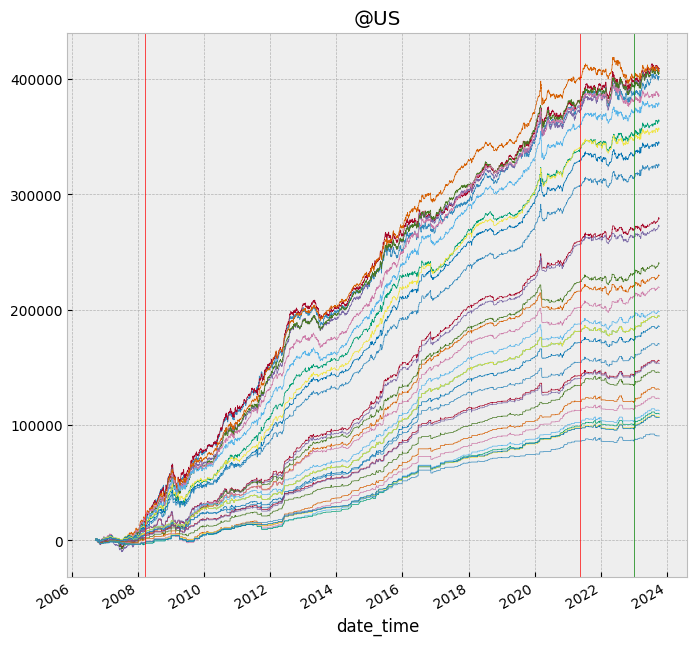

In [83]:
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)

costi = 0

test_ = []

for I in np.arange(0.5,0.8,0.01):

    pred_proba = best_clf.predict_proba(X0[selected_features].values)
    proba = (np.amax(pred_proba, axis=1) > I).astype(int)
    
    cc = dataset.PNL.to_frame().copy()
    cc["pred"] = pred
    cc["pred"][cc["pred"]==0]=-1
    
    cc["proba"] = proba
    cc["clean_pred"] = np.where(cc["proba"]==0,0,cc.pred)
    
    cc["costi"] = np.where((cc.pred!=cc.pred.shift(1)),-costi,0)
    cc["costi_proba"] = np.where((cc.clean_pred!=cc.clean_pred.shift(1)),-costi,0)
    
    cc["nb"] = cc.PNL*cc.pred.shift(1)
    cc["nb"] = cc["nb"] + cc["costi"] 
    cc["nb_proba"] = cc.PNL*cc["clean_pred"].shift(1)
    cc["nb_proba"] = cc["nb_proba"] + cc["costi_proba"]
    cc = cc.fillna(0)
    
    #cc["nb"].cumsum().plot(title=simbolo)
    cc["nb_proba"].cumsum().plot(title=simbolo)
    cc["nb_proba"]=cc["nb_proba"][cc["nb_proba"]!=0]
    test_.append([I,cc["nb_proba"].sum(),len(cc["nb_proba"][cc["nb_proba"]!=0]),percent_win(cc["nb_proba"].loc[:y_test.index[0]]),percent_win(cc["nb_proba"].loc[y_test.index[0]:])])

plt.axvline(x=y_train.index[validation_data] ,color = "red" )
plt.axvline(x=y_train.index[-1] ,color = "red" )
plt.axvline(x="2023-01-01" ,color = "green" )
plt.show()

<Axes: >

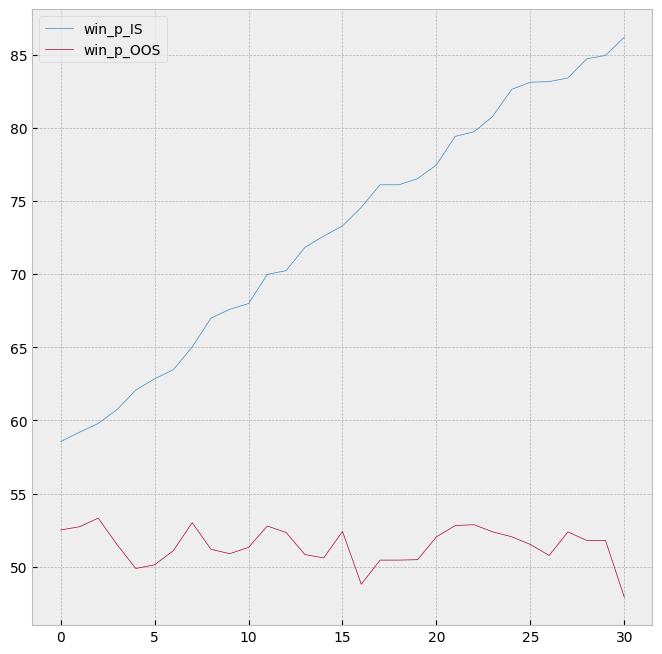

In [87]:
test_ = pd.DataFrame(test_)
test_.columns=(["value","pnl","n_op","win_p_IS","win_p_OOS"])
test_[["win_p_IS","win_p_OOS"]].plot()

In [85]:
test_

,value,pnl,n_op,win_p_IS,win_p_OOS
0,0.50,401531.25,4432,58.55,52.51
1,0.51,408718.75,4432,59.19,52.73
2,0.52,406468.75,4432,59.79,53.32
3,0.53,404812.50,4432,60.74,51.51
4,0.54,407062.50,4432,62.07,49.88
5,0.55,385406.25,4432,62.84,50.13
6,0.56,378218.75,4432,63.47,51.10
7,0.57,363468.75,4432,65.01,53.01
8,0.58,356437.50,4432,66.99,51.19
9,0.59,344437.50,4432,67.59,50.89
